In [2]:
import pandas as pd
import warnings
import os
from app.data_managers.namespaces import data_ns, files_ns

warnings.filterwarnings("ignore")
path = os.path.join(files_ns.DATA_FOLDER, files_ns.CURATED_FOLDER, files_ns.ENERGY_PRICE)

price = pd.read_csv(path, index_col=data_ns.TIME, parse_dates=[data_ns.TIME]).asfreq("H")

In [4]:
from app.modeling.pipeline import Pipeline

from app.modeling.transformers.transformers import (
    CO2PricesProvider,
    EnergyDemandProvider,
    FuelPricesProvider,
    LinearInterpolator,
    TemperatureProvider,
    WindSpeedProvider,
)

pipe = Pipeline([
    ("interploate", LinearInterpolator()),
    ("wind_speed", WindSpeedProvider()),
    ("temperature", TemperatureProvider()),
    ("fuel", FuelPricesProvider()),
    ("demand", EnergyDemandProvider()),
    ("co2", CO2PricesProvider()),
])

X = pipe.fit_transform(price)
X.head()

,VALUE,Wind_Speed,Temperature,FUEL_PRICE,DEMAND,CO2_PRICE
TIME,,,,,,
2018-01-01 01:00:00,72.05,13.0,8.0,3628.0,14978.538,32.5
2018-01-01 02:00:00,72.05,14.0,8.0,3628.0,14397.650,32.5
2018-01-01 03:00:00,72.05,13.0,9.0,3628.0,13789.463,32.5
2018-01-01 04:00:00,72.05,16.0,9.0,3628.0,13434.450,32.5
2018-01-01 05:00:00,71.15,16.0,8.0,3628.0,13285.238,32.5


In [36]:
def cc(df: pd.DataFrame):
    print(df)

hourly = X[["VALUE", "Wind_Speed", "Temperature", "DEMAND"]]
g = hourly.groupby([hourly.index.day, hourly.index.month, hourly.index.year]).corr("spearman")['VALUE']
g.index

MultiIndex([( 1,  1, 2018,       'VALUE'),
            ( 1,  1, 2018,  'Wind_Speed'),
            ( 1,  1, 2018, 'Temperature'),
            ( 1,  1, 2018,      'DEMAND'),
            ( 1,  1, 2019,       'VALUE'),
            ( 1,  1, 2019,  'Wind_Speed'),
            ( 1,  1, 2019, 'Temperature'),
            ( 1,  1, 2019,      'DEMAND'),
            ( 1,  1, 2020,       'VALUE'),
            ( 1,  1, 2020,  'Wind_Speed'),
            ...
            (31, 12, 2020, 'Temperature'),
            (31, 12, 2020,      'DEMAND'),
            (31, 12, 2021,       'VALUE'),
            (31, 12, 2021,  'Wind_Speed'),
            (31, 12, 2021, 'Temperature'),
            (31, 12, 2021,      'DEMAND'),
            (31, 12, 2022,       'VALUE'),
            (31, 12, 2022,  'Wind_Speed'),
            (31, 12, 2022, 'Temperature'),
            (31, 12, 2022,      'DEMAND')],
           names=['TIME', 'TIME', 'TIME', None], length=7584)

In [37]:
g.index = g.index.droplevel(level=[0,1,2])
g.groupby(by=g.index.to_list()).mean()

DEMAND         0.607980
Temperature    0.329342
VALUE          1.000000
Wind_Speed     0.114549
Name: VALUE, dtype: float64

In [77]:
from functools import reduce

indexes = list(map(lambda df: df.index, dfs))
idx = list(reduce(lambda idx1, idx2: idx1.intersection(idx2), indexes))

In [78]:
dfs_m = [df.loc[idx] for df in dfs]
data = pd.concat(dfs_m, axis=1).interpolate()

data.corr()

,Cena_Energii,Zapotrzebowanie,CO2,Cena_Paliwa,Temperature,Wind_Speed
Cena_Energii,1.000000,0.240761,0.821699,0.801104,0.013158,-0.053251
Zapotrzebowanie,0.240761,1.000000,0.126961,0.042171,-0.443928,0.091072
CO2,0.821699,0.126961,1.000000,0.842084,-0.071173,0.102423
Cena_Paliwa,0.801104,0.042171,0.842084,1.000000,0.113891,0.019531
Temperature,0.013158,-0.443928,-0.071173,0.113891,1.000000,-0.176383
Wind_Speed,-0.053251,0.091072,0.102423,0.019531,-0.176383,1.000000


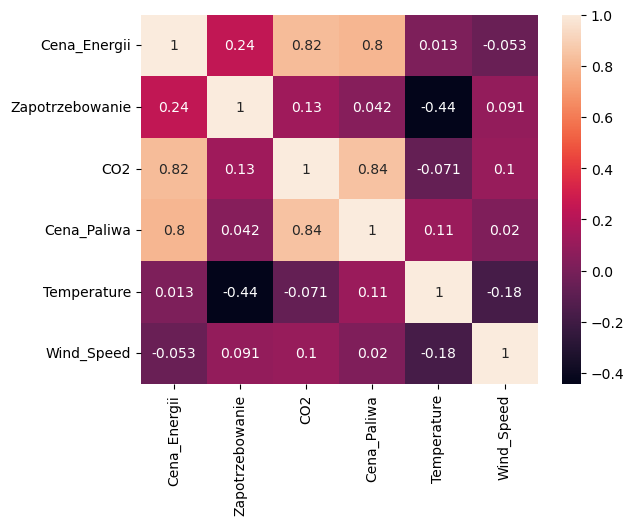

In [79]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True);

In [38]:
ix = demand.index.intersection(sett.index, weather.index)

# demand.loc[ix].corr(sett.loc[ix], method="pearson")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [23]:
ix = co2.index.intersection(sett.index)

co2.loc[ix, "VALUE"].corr(sett.loc[ix], method="pearson")

0.8315722998707044

In [5]:
demand.describe()

count    45490.000000
mean     19491.506682
std       3214.648200
min      10768.725000
25%      16805.687500
50%      19573.313000
75%      21989.025500
max      27374.675000
Name: VALUE, dtype: float64

In [9]:
price.resample("D").mean().nsmallest(5)

TIME
2020-04-12    12629.085583
2020-04-13    12771.000250
2019-04-21    13197.891375
2019-04-22    13311.220542
2020-05-03    13457.249750
Name: VALUE, dtype: float64

In [10]:
price.resample("M").mean()

TIME
2018-01-31    20715.238104
2018-02-28    21364.367287
2018-03-31    20770.556008
2018-04-30    18337.743571
2018-05-31    17966.708167
                  ...     
2022-11-30    20387.414951
2022-12-31    20860.309297
2023-01-31    20280.386294
2023-02-28    20787.563022
2023-03-31    20963.705682
Freq: M, Name: VALUE, Length: 63, dtype: float64

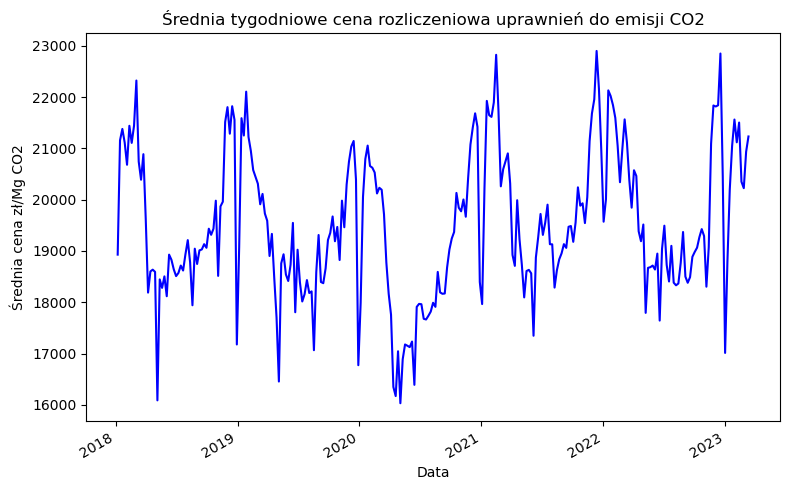

In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(price.resample("W").mean(), color="blue")
plt.xticks(rotation=30, ha='right')
 
plt.title('Średnie tygodniowe zapotrzebowanie na energię elektryczną')
 
plt.xlabel('Data')
plt.ylabel('Średnia zapotrzebowanie [kWh]')
plt.tight_layout()


In [12]:
x = price.argmax()
price.iloc[x: x+2]

TIME
2021-02-12 11:00:00    27374.675
2021-02-12 12:00:00    27345.000
Name: VALUE, dtype: float64

In [13]:
from pandas import Grouper

groups = price.groupby(Grouper(freq='A'))
years = pd.DataFrame()

groups.agg("mean")
    
# years.boxplot()

TIME
2018-12-31    19532.927839
2019-12-31    19283.518723
2020-12-31    18816.923261
2021-12-31    19935.702127
2022-12-31    19680.608532
2023-12-31    20589.298578
Freq: A-DEC, Name: VALUE, dtype: float64

In [14]:
from datetime import datetime

y = 2000

def get_season(x: datetime) -> str:
    x = x.replace(year=y)
    
    if x < datetime(y, 3, 21) or x > datetime(y, 12, 22):
        return "Zima"
    elif x < datetime(y, 6, 22):
        return "Wiosna"
    elif x < datetime(y, 9, 23):
        return "Lato"
    else:
        return "Jesień"

holidays = pd.read_csv("holidays.csv", parse_dates=["Date"], usecols=["Date"]).squeeze().to_list()



In [15]:
df = price.to_frame()
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Season"] = list(map(get_season, df.index))
df["Day"] = list(map(lambda x: x.day, df.index))
df["Day_Of_Week"] = list(map(lambda x: x.dayofweek + 1, df.index))
df["Day_Name"] = list(map(lambda x: x.day_name(), df.index))
df["Is_Day_Off"] = list(map(lambda x: x.replace(hour=0) in holidays or x.day_name() in {"Sunday", "Suturday"}, df.index))
df["Hour"] = list(map(lambda x: x.hour, df.index))



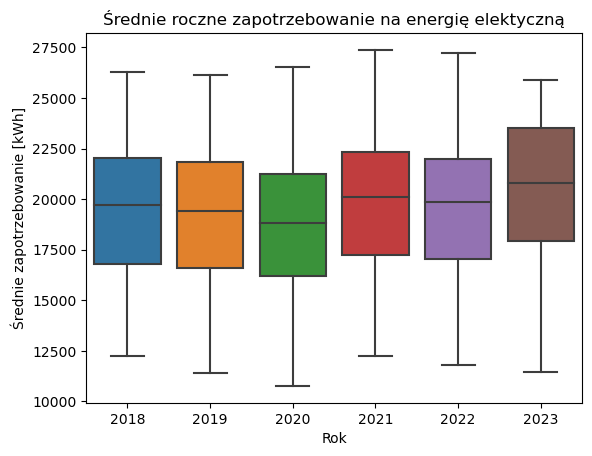

In [16]:
import seaborn as sns


sns.boxplot(data=df, x="Year", y="VALUE").set(
    title='Średnie roczne zapotrzebowanie na energię elektyczną',
    xlabel='Rok',
    ylabel='Średnie zapotrzebowanie [kWh]'
);

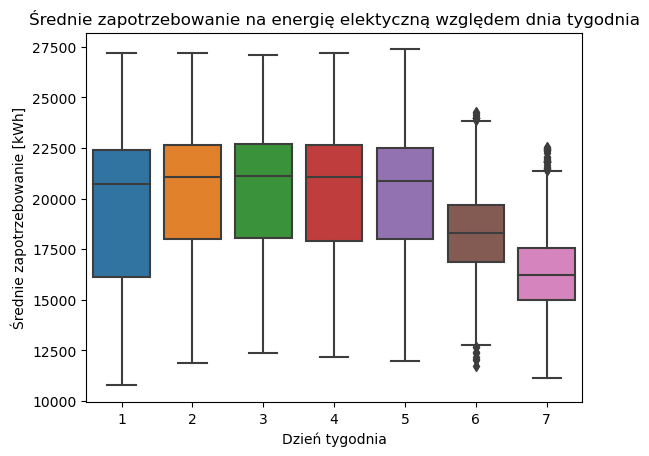

In [17]:
sns.boxplot(data=df[df["Year"] < 2023], x="Day_Of_Week", y="VALUE").set(
    title='Średnie zapotrzebowanie na energię elektyczną względem dnia tygodnia',
    xlabel='Dzień tygodnia',
    ylabel='Średnie zapotrzebowanie [kWh]'
);


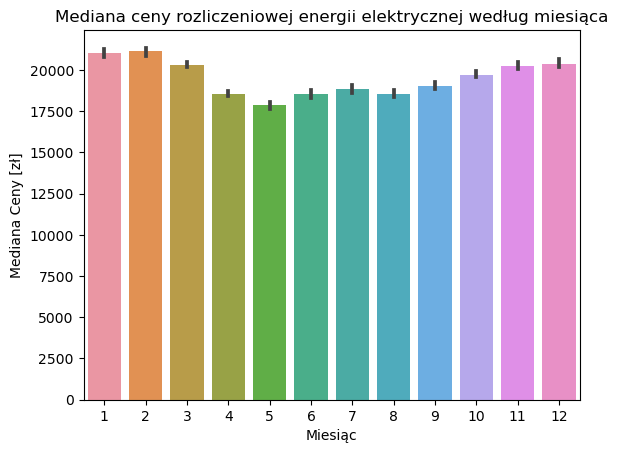

In [18]:
sns.barplot(data=df[df["Year"] < 2023], x="Month", y="VALUE", estimator="median").set(
 
    title='Mediana ceny rozliczeniowej energii elektrycznej według miesiąca',
    xlabel='Miesiąc',
    ylabel='Mediana Ceny [zł]'
    
);

C:\Users\wojtek\AppData\Local\Temp\ipykernel_20760\899158602.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g.groupby("Is_Day_Off").mean(


,VALUE,Year,Month,Day,Day_Of_Week,Hour
Is_Day_Off,,,,,,
Nie,20134.499500,2020.114444,6.323125,15.789266,3.507182,11.498579
Tak,16225.151293,2020.090083,6.467789,14.986768,6.490778,11.507217


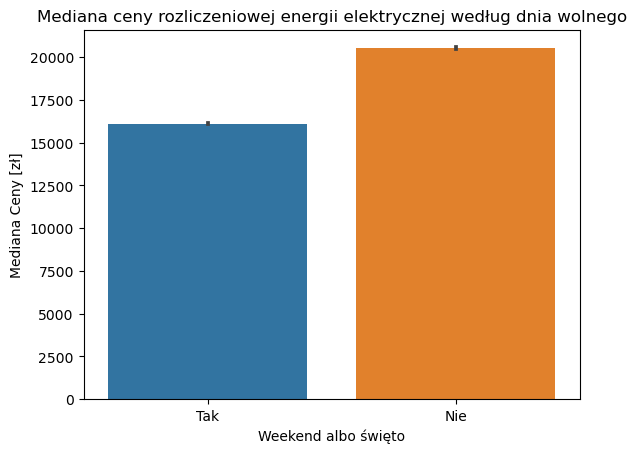

In [19]:
g = df.replace({False: "Nie", True: "Tak"})
fig = sns.barplot(data=g[g["Year"] < 2023], x="Is_Day_Off", y="VALUE", estimator="median").set(
 
    title='Mediana ceny rozliczeniowej energii elektrycznej według dnia wolnego',
    xlabel='Weekend albo święto',
    ylabel='Mediana Ceny [zł]'
    
);
g.groupby("Is_Day_Off").mean(
)

In [20]:
g

,VALUE,Year,Month,Season,Day,Day_Of_Week,Day_Name,Is_Day_Off,Hour
TIME,,,,,,,,,
2018-01-01 01:00:00,14978.538,2018,1,Zima,1,1,Monday,Tak,1
2018-01-01 02:00:00,14397.650,2018,1,Zima,1,1,Monday,Tak,2
2018-01-01 03:00:00,13789.463,2018,1,Zima,1,1,Monday,Tak,3
2018-01-01 04:00:00,13434.450,2018,1,Zima,1,1,Monday,Tak,4
2018-01-01 05:00:00,13285.238,2018,1,Zima,1,1,Monday,Tak,5
...,...,...,...,...,...,...,...,...,...
2023-03-11 13:00:00,21443.050,2023,3,Zima,11,6,Saturday,Nie,13
2023-03-11 14:00:00,21364.850,2023,3,Zima,11,6,Saturday,Nie,14
2023-03-11 15:00:00,20882.400,2023,3,Zima,11,6,Saturday,Nie,15


In [21]:
price.describe()

count    45490.000000
mean     19491.506682
std       3214.648200
min      10768.725000
25%      16805.687500
50%      19573.313000
75%      21989.025500
max      27374.675000
Name: VALUE, dtype: float64

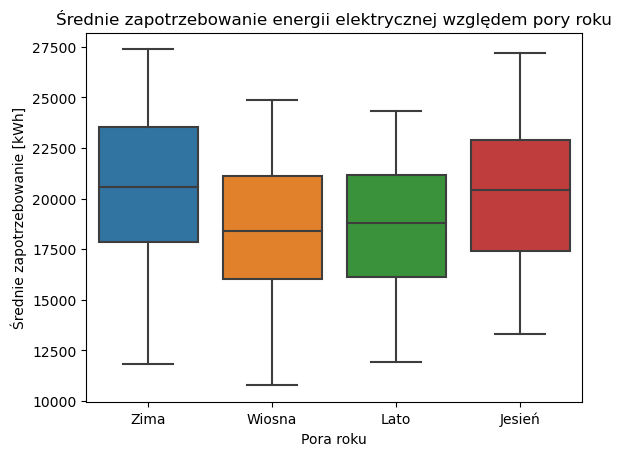

In [22]:
sns.boxplot(data=df[df["Year"] < 2023], x="Season", y="VALUE").set(
    title='Średnie zapotrzebowanie energii elektrycznej względem pory roku',
    xlabel='Pora roku',
    ylabel='Średnie zapotrzebowanie [kWh]'
);

In [23]:
df[df["Year"] < 2023] . groupby("Season").mean()

C:\Users\wojtek\AppData\Local\Temp\ipykernel_20760\3833529431.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df["Year"] < 2023] . groupby("Season").mean()


,VALUE,Year,Month,Day,Day_Of_Week,Is_Day_Off,Hour
Season,,,,,,,
Jesień,20268.649655,2020.000000,10.711708,15.602962,3.995743,0.160019,11.494678
Lato,18616.747217,2020.000000,7.709677,15.903226,3.997849,0.150538,11.500000
Wiosna,18439.768714,2020.000000,4.667414,15.887046,3.998655,0.180278,11.503810
Zima,20544.210424,2020.000187,2.993737,15.500561,4.000093,0.170312,11.506450


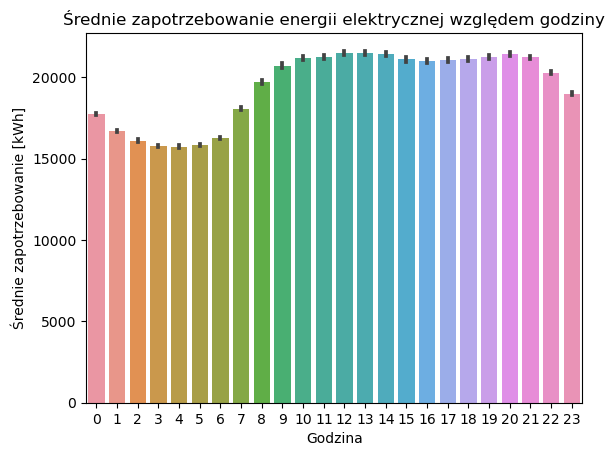

In [24]:
sns.barplot(data=df[df["Year"] < 2023], x="Hour", y="VALUE").set(
    title='Średnie zapotrzebowanie energii elektrycznej względem godziny',
    xlabel='Godzina',
    ylabel='Średnie zapotrzebowanie [kWh]'
);

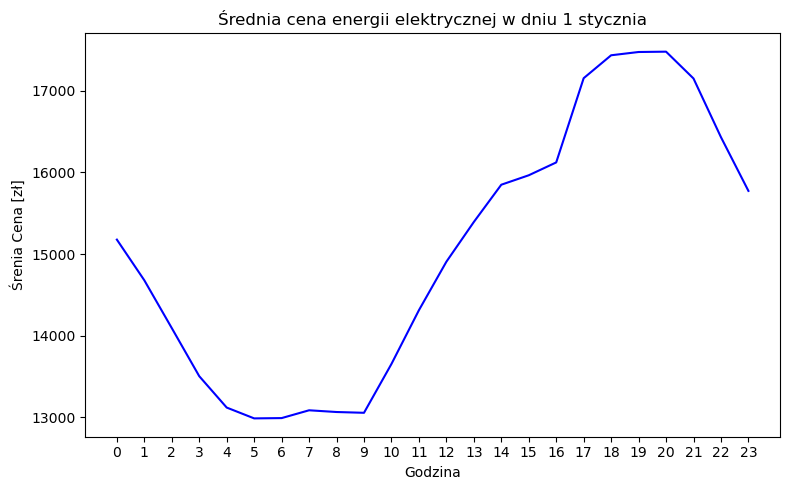

In [25]:
x = (df.index.day == 1) & (df.index.month == 1) 

ny = df.loc[x] 
mean = ny.groupby(ny.index.hour)["VALUE"].mean()

plt.figure(figsize=(8, 5))
plt.plot(mean, color="blue")
plt.xticks(range(0,24))
 
plt.title('Średnia cena energii elektrycznej w dniu 1 stycznia')
 
plt.xlabel('Godzina')
plt.ylabel('Śrenia Cena [zł]')
plt.tight_layout()

<AxesSubplot: xlabel='Month,Day'>

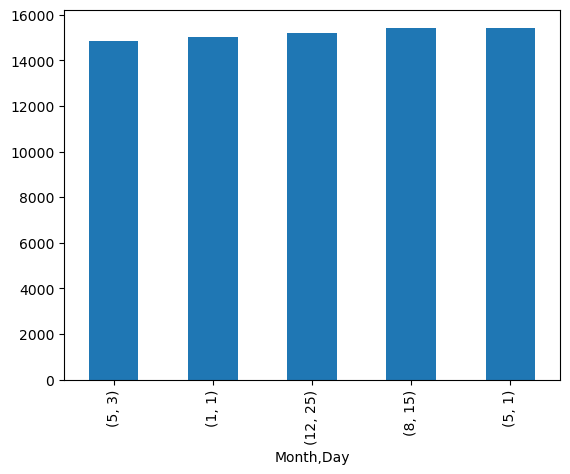

In [26]:
e = df.groupby([df.index.day, df.index.month])["VALUE"].mean().sort_values().iloc[:5]

c = [df.query("Day == {day} & Month == {month}".format(day=index[0], month=index[1])) for index in e.index]
# c.groupby(["Month", "Day"], as_index=False)["VALUE"].mean()
l = pd.concat(c).groupby(["Month", "Day"])["VALUE"].mean().sort_values()

# sns.barplot(data=l).set(
#     title='Mediana ceny rozliczeniowej energii elektrycznej dla pór roku',
#     xlabel='Pora roku',
#     ylabel='Mediana Ceny [zł]'
# );
l.plot.bar()

In [27]:
x = df["VALUE"].idxmin()

df.loc[x]

VALUE          10768.725
Year                2020
Month                  4
Season            Wiosna
Day                   13
Day_Of_Week            1
Day_Name          Monday
Is_Day_Off          True
Hour                   7
Name: 2020-04-13 07:00:00, dtype: object

In [28]:
demand = pd.read_csv("data/energy_demand.csv", parse_dates=["TIME"], index_col="TIME")["VALUE"]
demand

TIME
2018-01-01 01:00:00    14978.538
2018-01-01 02:00:00    14397.650
2018-01-01 03:00:00    13789.463
2018-01-01 04:00:00    13434.450
2018-01-01 05:00:00    13285.238
                         ...    
2023-03-11 13:00:00    21443.050
2023-03-11 14:00:00    21364.850
2023-03-11 15:00:00    20882.400
2023-03-11 16:00:00    20525.525
2023-03-11 17:00:00    20362.850
Name: VALUE, Length: 45492, dtype: float64

In [29]:
demand.groupby(demand.index.month).mean().sort_values()

TIME
5     17961.391215
6     18495.010803
8     18504.116429
4     18554.487403
7     18582.800845
9     18838.855995
10    19550.177894
3     20252.307102
11    20304.834898
12    20611.232453
1     20787.329642
2     20956.274259
Name: VALUE, dtype: float64